In [130]:
import pandas as pd
import numpy as np
import datasets
import torch
import os
from datasets import load_dataset, load_from_disk, concatenate_datasets
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification
from transformers import Trainer
from sklearn.model_selection import train_test_split
import evaluate

In [131]:
dirname = os.path.abspath('')
dataset_de_dir = os.path.join(dirname, "..\\data\\reviews_de.csv")
dataset_en_dir = os.path.join(dirname, '..\\data\\HateSpeechRecoginition\\bestande_translations_clean.csv')

dataset_de = pd.read_csv(dataset_de_dir)
dataset_en = pd.read_csv(dataset_en_dir)

print(len(dataset_de))
print(len(dataset_en))

6642
2840


In [132]:
# Remove not important columns
dataset_de = dataset_de.drop(columns=['university', 'course', 'date', 'courseName', 'courseNameShort'])
dataset_en = dataset_en.drop(columns=['university', 'course', 'date', 'courseName', 'courseNameShort', 'review', 'translation'])

In [133]:
dataset_en = dataset_en.rename({'translations': 'review'}, axis=1)
dataset_en = dataset_en.drop(dataset_en.columns[[0]], axis=1)

In [134]:
dataset = pd.concat([dataset_de, dataset_en])
dataset

,_id,review,score,upvotes,downvotes
0,5a5b6dfbaf6c59001a536aeb,interessantes aber sehr aufwändiges Fach. Die ...,3,0.0,1.0
1,5a5b70abaf6c59001a536b07,Warum wird Moodle Verwendet & nicht OLAT? Anso...,4,4.0,8.0
2,5a5b729faf6c59001a536b13,"langwiilig, Management teil nutzlos, nur uswän...",2,0.0,1.0
3,5a5b7ae5af6c59001a536b80,In diesem Fach zeichnet man Flowcharts und Pro...,3,0.0,0.0
4,5a5b7d07af6c59001a536b87,weiss nöd warum so viel klaget. de dozent isch...,5,1.0,0.0
...,...,...,...,...,...
2835,6318e504e3b1d00021a54004,"Sehr schwierig, wenn Sie nichts über Fotografi...",2,0.0,0.0
2836,6323dee79e3a200021c9d930,"Sehr interessanter Kurs, der einige sehr wicht...",5,0.0,0.0
2837,633da31e15d83c0021cf43f3,"Wirklich, verdammt langweilig...",2,0.0,0.0
2838,6356696e05897c00219dfe03,Gute Einführung in die Programmierung in Pytho...,3,0.0,0.0


In [135]:
dataset['sum'] = dataset['upvotes']-dataset['downvotes']
dataset

,_id,review,score,upvotes,downvotes,sum
0,5a5b6dfbaf6c59001a536aeb,interessantes aber sehr aufwändiges Fach. Die ...,3,0.0,1.0,-1.0
1,5a5b70abaf6c59001a536b07,Warum wird Moodle Verwendet & nicht OLAT? Anso...,4,4.0,8.0,-4.0
2,5a5b729faf6c59001a536b13,"langwiilig, Management teil nutzlos, nur uswän...",2,0.0,1.0,-1.0
3,5a5b7ae5af6c59001a536b80,In diesem Fach zeichnet man Flowcharts und Pro...,3,0.0,0.0,0.0
4,5a5b7d07af6c59001a536b87,weiss nöd warum so viel klaget. de dozent isch...,5,1.0,0.0,1.0
...,...,...,...,...,...,...
2835,6318e504e3b1d00021a54004,"Sehr schwierig, wenn Sie nichts über Fotografi...",2,0.0,0.0,0.0
2836,6323dee79e3a200021c9d930,"Sehr interessanter Kurs, der einige sehr wicht...",5,0.0,0.0,0.0
2837,633da31e15d83c0021cf43f3,"Wirklich, verdammt langweilig...",2,0.0,0.0,0.0
2838,6356696e05897c00219dfe03,Gute Einführung in die Programmierung in Pytho...,3,0.0,0.0,0.0


In [136]:
# Mapping

# All <=0 values to 0 : neutral review
dataset['sum'] = dataset['sum'].apply(lambda x: max(x, 0))
dataset.to_csv('../data/ReviewPrediction/dataset_no_negative.csv')
dataset

,_id,review,score,upvotes,downvotes,sum
0,5a5b6dfbaf6c59001a536aeb,interessantes aber sehr aufwändiges Fach. Die ...,3,0.0,1.0,0.0
1,5a5b70abaf6c59001a536b07,Warum wird Moodle Verwendet & nicht OLAT? Anso...,4,4.0,8.0,0.0
2,5a5b729faf6c59001a536b13,"langwiilig, Management teil nutzlos, nur uswän...",2,0.0,1.0,0.0
3,5a5b7ae5af6c59001a536b80,In diesem Fach zeichnet man Flowcharts und Pro...,3,0.0,0.0,0.0
4,5a5b7d07af6c59001a536b87,weiss nöd warum so viel klaget. de dozent isch...,5,1.0,0.0,1.0
...,...,...,...,...,...,...
2835,6318e504e3b1d00021a54004,"Sehr schwierig, wenn Sie nichts über Fotografi...",2,0.0,0.0,0.0
2836,6323dee79e3a200021c9d930,"Sehr interessanter Kurs, der einige sehr wicht...",5,0.0,0.0,0.0
2837,633da31e15d83c0021cf43f3,"Wirklich, verdammt langweilig...",2,0.0,0.0,0.0
2838,6356696e05897c00219dfe03,Gute Einführung in die Programmierung in Pytho...,3,0.0,0.0,0.0


In [137]:
# Obtain mean of non-zero elements
dataset_mean = dataset[dataset['sum'] != 0]['sum'].mean()

<Axes: >

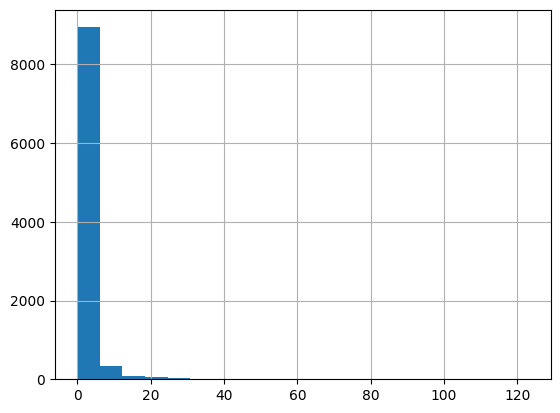

In [138]:
import matplotlib.pyplot as plt

dataset['sum'].hist(bins=20)

<Axes: >

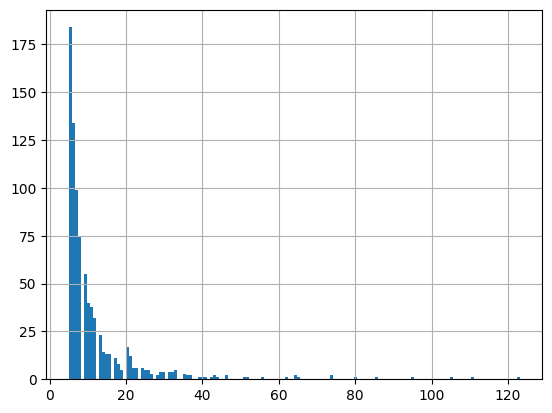

In [139]:
dataset[dataset['sum']>dataset_mean]['sum'].hist(bins=150)

In [140]:
type(dataset['sum'].iloc[1])

numpy.float64

In [141]:
print(len(dataset))
dataset.dropna(subset=['sum'], inplace=True)
print(len(dataset))

9482
9482


In [142]:
# Mapping
# Everything below the mean -> 1 : moderately useful
# Everything above the mean and below 2*mean : useful
# Everything above 2*the mean : super useful
def map_to_stars(value):
    if value == 0:
        pass
    elif value > 0 and value < dataset_mean:
        value = 1
    elif value>dataset_mean and value < 2*dataset_mean:
        value = 2
    else:
        value = 3
    return value
        
#avoid having 0 to imitate a star rating, in this case 0-4
def add_one(value):
    return value+1

dataset['sum'] = dataset['sum'].map(lambda x: map_to_stars(x))
dataset['sum'] = dataset['sum'].map(lambda x: add_one(x))


In [143]:
dataset.to_csv('../data/ReviewPrediction/dataset_stars.csv')

In [144]:
dataset

,_id,review,score,upvotes,downvotes,sum
0,5a5b6dfbaf6c59001a536aeb,interessantes aber sehr aufwändiges Fach. Die ...,3,0.0,1.0,1.0
1,5a5b70abaf6c59001a536b07,Warum wird Moodle Verwendet & nicht OLAT? Anso...,4,4.0,8.0,1.0
2,5a5b729faf6c59001a536b13,"langwiilig, Management teil nutzlos, nur uswän...",2,0.0,1.0,1.0
3,5a5b7ae5af6c59001a536b80,In diesem Fach zeichnet man Flowcharts und Pro...,3,0.0,0.0,1.0
4,5a5b7d07af6c59001a536b87,weiss nöd warum so viel klaget. de dozent isch...,5,1.0,0.0,2.0
...,...,...,...,...,...,...
2835,6318e504e3b1d00021a54004,"Sehr schwierig, wenn Sie nichts über Fotografi...",2,0.0,0.0,1.0
2836,6323dee79e3a200021c9d930,"Sehr interessanter Kurs, der einige sehr wicht...",5,0.0,0.0,1.0
2837,633da31e15d83c0021cf43f3,"Wirklich, verdammt langweilig...",2,0.0,0.0,1.0
2838,6356696e05897c00219dfe03,Gute Einführung in die Programmierung in Pytho...,3,0.0,0.0,1.0


### Divide dataset into train, test, validation

In [145]:
train_dataset, test_dataset = train_test_split(dataset, train_size=0.85, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, train_size=0.95, random_state=42)

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

7656
1423
403


In [147]:
train_dataset.to_csv('../data/ReviewPrediction/train.csv')
test_dataset.to_csv('../data/ReviewPrediction/test.csv')
val_dataset.to_csv('../data/ReviewPrediction/validation.csv')

del train_dataset
del test_dataset
del val_dataset

## Load dataset as dataset object

In [149]:
dataset = load_dataset('../data/ReviewPrediction', data_files={'train': 'train.csv', 'test': 'test.csv', 'validation': 'validation.csv'})
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 7656
    })
    test: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 1423
    })
    validation: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 403
    })
})

In [153]:
checkpoint = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['review'], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset["train"][0]

Map:   0%|          | 0/1423 [00:00<?, ? examples/s]

{'Unnamed: 0': 2347,
 '_id': '61e0642e1875bb0021077478',
 'review': 'Alles irreführend mit diesem Kurs: Prüfungsrelevante Inhalte, Prüfungsfragen, Aufsicht oder keine Aufsicht, Dias und vieles mehr!',
 'score': 1,
 'upvotes': 0.0,
 'downvotes': 0.0,
 'sum': 1.0,
 'input_ids': [101,
  21785,
  10544,
  61581,
  19544,
  56772,
  10234,
  14296,
  33666,
  131,
  14853,
  77644,
  37696,
  12832,
  33248,
  10111,
  95942,
  10111,
  117,
  14853,
  77644,
  45220,
  41533,
  117,
  10350,
  47707,
  10843,
  14819,
  10350,
  47707,
  117,
  14347,
  10138,
  16994,
  10107,
  12600,
  106,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1

In [155]:
tokenized_dataset.remove_columns(["upvotes", "downvotes", "score", "Unnamed: 0"])
tokenized_dataset = tokenized_dataset.rename_column("sum", "labels")
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7656
    })
    test: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1423
    })
    validation: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 403
    })
})